# Learning a Prior for Magnetic Resonance Spectroscopy

This Notebook Includes:
1. **Data Processing**  
  a. Setup & Imports  
  b. Data Loading Utilities  
  c. Visualization Helpers  
  d. QC Data Processing

2. **Data Classes**  
  a. AGNOSTIC Data Class  
  b. Big GABA Data Class  

3. **Model Architecture**  
  a. Proximal Mathcing Loss Function  
  b. Simple 1D Proximal CNN (Proof of Concept)  
  c. 1D Input Convex Neural Network (ICNN)  
  d.

## **Data Processing**

In [1]:
## a. Setup & Imports

import os
import csv
import random
import json
import h5py
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn import MSELoss
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.utils.data import random_split
from torch.amp import GradScaler
from torch.amp import autocast

import pprint
import zipfile
from tqdm import tqdm
import time
import nibabel as nib
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
from random import sample
from scipy.signal import resample
from skimage.metrics import peak_signal_noise_ratio as psnr

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Path Definitions

CLEAN_ROOT = Path("/content/drive/MyDrive/ADSBME Project/MRS_Data/Clean_Data")
RAW_ROOT   = Path("/content/drive/MyDrive/ADSBME Project/MRS_Data/Raw_Data")
AGNOSTIC_ROOT = Path("/content/drive/MyDrive/ADSBME Project/MRS_Data/Raw_Data/Agnostic")
GABA_ROOT = Path("/content/drive/MyDrive/ADSBME Project/MRS_Data/Clean_Data/Big_Gaba")

In [3]:
# L2 Normalization

def l2_normalize(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    To avoid scale mismatch when comparing pred vs clean
    """
    norm = x.norm(p=2, dim=1, keepdim=True).clamp(min=eps)
    return x / norm

In [10]:
## b. Data Loading (AGNOSTIC)

def load_npz_pair(path: Path, target_len: int):
    arr = np.load(path, mmap_mode="r")
    clean = arr["Metab"] + arr["MM"] + arr["water"]
    noisy = clean + arr["noise"]
    samples = []
    for i in range(clean.shape[0]):
        spec_clean = np.abs(np.fft.fftshift(np.fft.fft(clean[i])))
        spec_noisy = np.abs(np.fft.fftshift(np.fft.fft(noisy[i])))
        cl = resample(spec_clean, target_len)
        no = resample(spec_noisy, target_len)
        cl = (cl - cl.mean()) / cl.std()
        no = (no - no.mean()) / no.std()
        samples.append((no.astype(np.float32), cl.astype(np.float32)))
    return samples

def plot_spectra(pairs, n=5, title_prefix="Sample"):
    """Plot n noisy/clean spectrum pairs from list or batch."""
    for i in range(n):
        noisy, clean = pairs[i]
        plt.figure(figsize=(6, 4))
        plt.plot(noisy, label="Noisy Input")
        plt.plot(clean, label="Clean Target")
        plt.title(f"{title_prefix} {i+1}")
        plt.xlabel("Index"); plt.ylabel("Intensity")
        plt.legend(); plt.tight_layout(); plt.show()


Raw AGNOSTIC spectra:


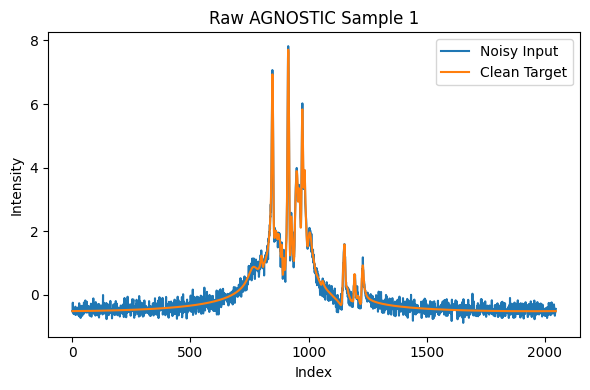

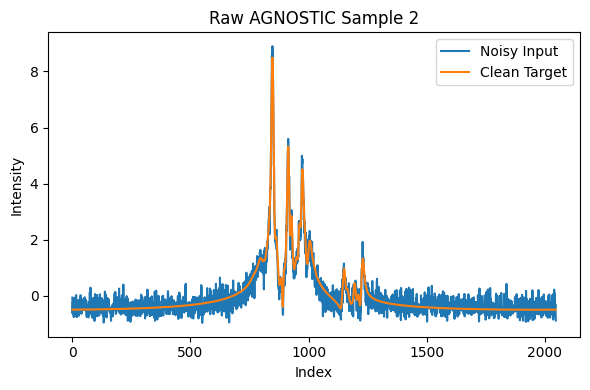

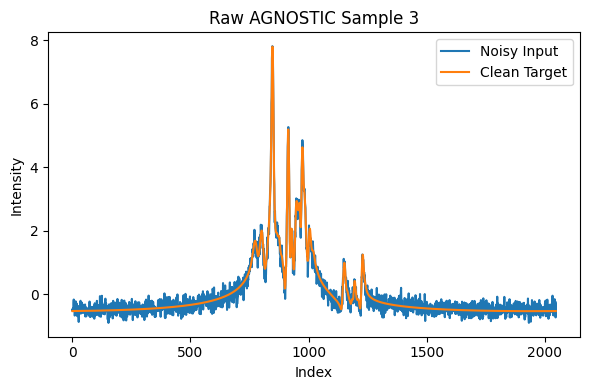

In [5]:
## c. Visualization (AGNOSTIC)

print("\nRaw AGNOSTIC spectra:")
preview_path = list(Path(AGNOSTIC_ROOT).rglob("data_*.npz"))[0]
preview_samples = load_npz_pair(preview_path, target_len=2048)
plot_spectra(preview_samples, n=3, title_prefix="Raw AGNOSTIC Sample")

In [12]:
## b. Data Loading (Big GABA)

# QC Data Loading

USECOLS = ['Cr_SNR', 'Cr_FWHM']

def _read_one_tsv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(
        path, sep="	", usecols=USECOLS, engine="c",
        dtype={'Cr_SNR': 'float32', 'Cr_FWHM': 'float32'}
    )
    df['vendor']  = path.parts[-3]
    df['subject'] = path.parts[-2]
    return df

def load_qc_metrics(base: Path, max_workers: int = 4) -> pd.DataFrame:
    tsv_dir = base / "Big_Gaba"
    tsv_paths = list(tsv_dir.rglob("QM_processed_spectra.tsv"))
    if not tsv_paths:
        return pd.DataFrame(columns=USECOLS + ['vendor', 'subject'])

    dfs = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(_read_one_tsv, p): p for p in tsv_paths}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading QC TSVs"):
            dfs.append(future.result())

    df = pd.concat(dfs, ignore_index=True)
    df.columns = df.columns.str.strip().str.lower()
    df = df.rename(columns={
        'cr_snr': 'Cr_SNR', 'cr_fwhm': 'Cr_FWHM',
        'vendor': 'vendor', 'subject': 'subject'
    })
    return df

# --- Load and view Big GABA QC metrics ---
qc_df = load_qc_metrics(CLEAN_ROOT, max_workers=4)
print("QC DataFrame preview:")
display(qc_df.head())

def load_processed(proc_path: Path):
    try:
        m = scipy.io.loadmat(str(proc_path), squeeze_me=True, struct_as_record=False)
        M = m['MRSCont']
        fid = M.raw[0,0].fids.flatten()
        spec = M.processed.metab[0,0].specs.flatten()
    except NotImplementedError:
        with h5py.File(str(proc_path), 'r') as f:
            g = f['MRSCont']
            r = f[g['raw'][0][0]]['fids']
            fid = r['real'][()] + 1j * r['imag'][()]
            p = f[g['processed']['metab'][0][0]]['specs']
            spec = p['real'][()] + 1j * p['imag'][()] if p.dtype.names else p[()]
    return fid, spec

def load_fit(fit_path: Path):
    fm = scipy.io.loadmat(str(fit_path), squeeze_me=True, struct_as_record=False)
    Fm = fm['fitMat']
    amps = np.array(Fm.results.metab.fitParams.ampl).flatten()
    rb = Fm.resBasisSet.metab
    name = rb._fieldnames[0]
    basis = np.array(getattr(rb, name).specs)
    return basis.dot(amps)

def _load_one_gaba(proc_path, fit_path, target_len):
    """Load and preprocess a single subject: return (noisy_spec, clean_spec)."""
    # 1) load raw FID + processed spectrum
    fid, proc_spec = load_processed(proc_path)

    # 2) coil‐RSS if needed
    if fid.ndim > 1:
        fid_mag = np.sqrt((np.abs(fid)**2).sum(axis=0))
    else:
        fid_mag = np.abs(fid)

    # 3) raw spectrum (FFT magnitude)
    raw_fft = np.fft.fftshift(np.fft.fft(fid_mag))
    spec_noisy = np.abs(raw_fft)

    # 4) clean spectrum (already freq‐domain)
    spec_clean = np.abs(proc_spec.flatten())

    # 5) resample to common length
    if spec_noisy.size != target_len:
        spec_noisy = resample(spec_noisy, target_len)
    if spec_clean.size != target_len:
        spec_clean = resample(spec_clean, target_len)

    # 6) normalize zero‐mean, unit‐var
    # spec_noisy = (spec_noisy - spec_noisy.mean()) / spec_noisy.std()
    # spec_clean = (spec_clean - spec_clean.mean()) / spec_clean.std()

    return spec_noisy.astype(np.float32), spec_clean.astype(np.float32)

def plot_spectra_gaba(fid, proc_spec, fit_spec, vendor=None, subject=None, qc=None):
    raw_fft = np.fft.fftshift(np.fft.fft(fid), axes=-1)
    raw_mag = np.abs(raw_fft)
    if raw_mag.ndim > 1:
        raw_mag = np.sqrt((raw_mag**2).sum(axis=0))
    raw_mag = raw_mag.flatten()

    ppm_raw = np.linspace(-5, 5, len(raw_mag))
    proc_mag = np.abs(proc_spec).flatten()
    ppm_proc = np.linspace(-5, 5, len(proc_mag))
    fit_mag = np.abs(fit_spec).flatten()
    ppm_fit = np.linspace(-5, 5, len(fit_mag))

    fig, (ax_raw, ax_proc, ax_fit) = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
    ax_raw.plot(ppm_raw, raw_mag)
    ax_raw.invert_xaxis()
    if vendor or subject:
        ax_raw.set_ylabel(f"{vendor or ''}\n{subject or ''}", fontsize=12)
    ax_raw.set_title("Raw spectrum")

    ax_proc.plot(ppm_proc, proc_mag)
    ax_proc.invert_xaxis()
    title = "Osprey processed"
    if isinstance(qc, dict):
        snr = qc.get("Cr_SNR")
        fwhm = qc.get("Cr_FWHM")
        if snr is not None and fwhm is not None:
            title += f"\nSNR: {snr:.1f}, FWHM: {fwhm:.2f} Hz"
    ax_proc.set_title(title)

    ax_fit.plot(ppm_fit, fit_mag)
    ax_fit.invert_xaxis()
    ax_fit.set_title("Synthesized fit")

    plt.tight_layout()
    plt.show()

Loading QC TSVs: 100%|██████████| 219/219 [00:00<00:00, 867.40it/s]

QC DataFrame preview:


,Cr_SNR,Cr_FWHM,vendor,subject
0,96.739777,6.709134,GE,G4_S03
1,79.998978,6.871166,GE,G4_S04
2,113.426498,6.039194,GE,G4_S06
3,100.184738,6.403820,GE,G4_S05
4,99.211159,5.678400,GE,G4_S07


Big GABA Spectra:


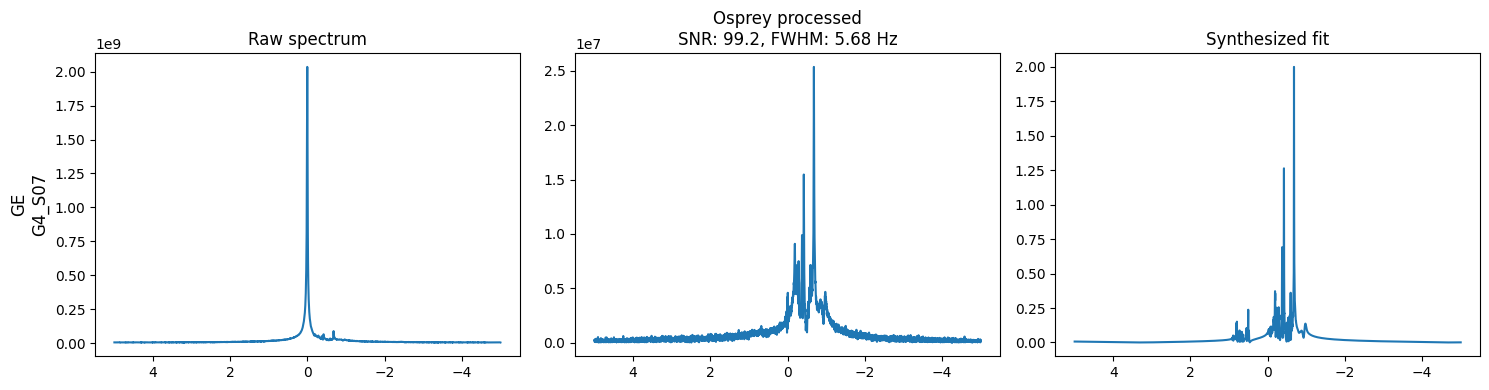

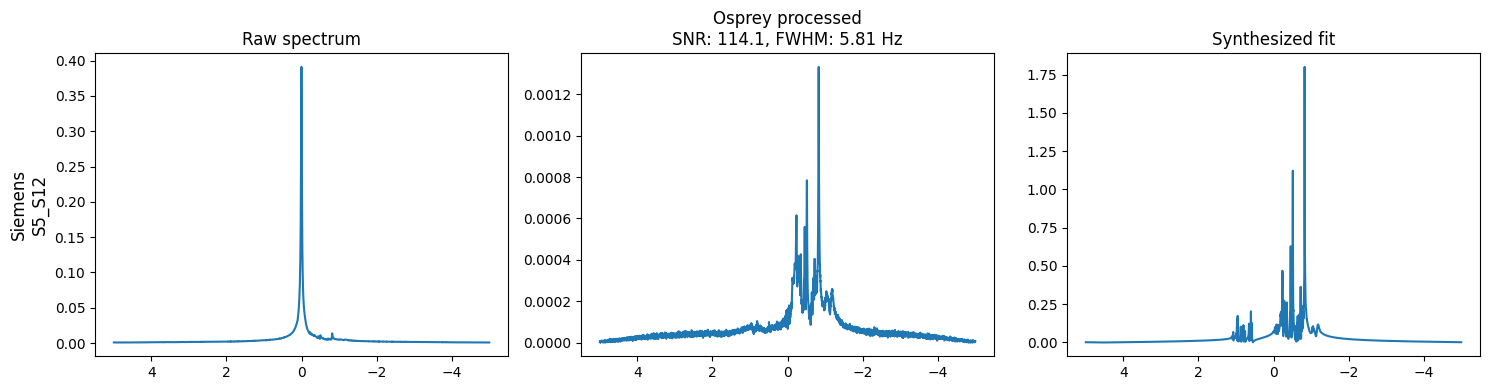

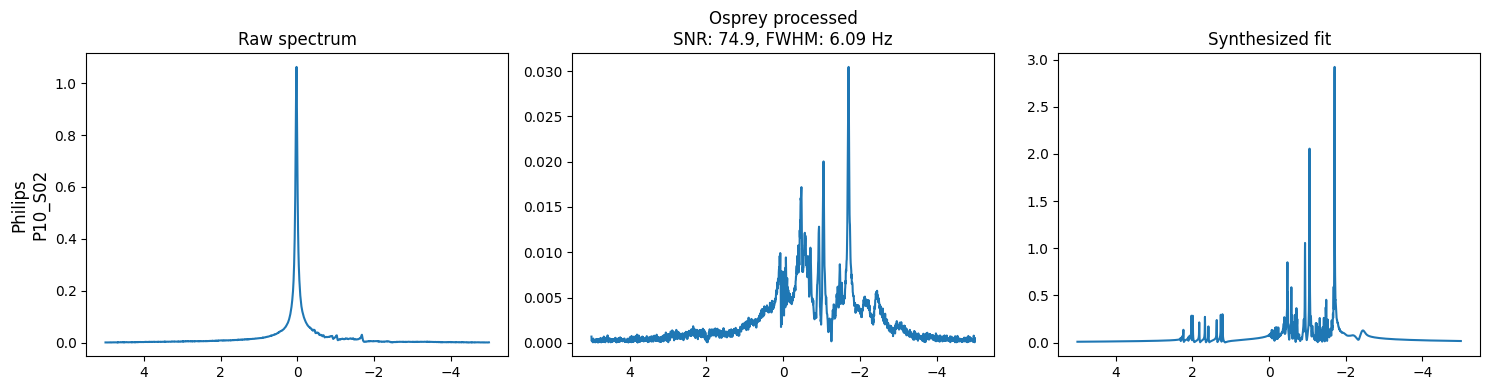

In [13]:
## c. Visualization (Big GABA)

print("Big GABA Spectra:")
proc_files = list((CLEAN_ROOT / "Big_Gaba").rglob("*/processed.mat"))
pairs = [(p, p.parent / "fit.mat") for p in proc_files if (p.parent / "fit.mat").exists()]

for proc_mat, fit_mat in sample(pairs, min(3, len(pairs))):
    vend, subj = proc_mat.parts[-3], proc_mat.parts[-2]
    fid, proc_spec = load_processed(proc_mat)
    fit_spec = load_fit(fit_mat)

    row = qc_df[(qc_df.vendor == vend) & (qc_df.subject == subj)]
    qc = row.iloc[0].to_dict() if not row.empty else {}

    plot_spectra_gaba(fid, proc_spec, fit_spec, vendor=vend, subject=subj, qc=qc)


## **Data Classes**

In [8]:
# Agnostic Data Class

class AgnosticDataset(Dataset):
    def __init__(self, agnostic_dir: str, target_len: int = 2048, max_workers: int = 4):
        files = list(Path(agnostic_dir).rglob("data_*.npz"))
        all_clean, all_noisy = [], []
        with ProcessPoolExecutor(max_workers=max_workers) as exe:
            futures = [exe.submit(load_npz_pair, p, target_len) for p in files]
            all_raw = []
            for fut in tqdm(as_completed(futures), total=len(futures), desc="Loading AGNOSTIC"):
                all_raw.extend(fut.result())

        for no, cl in all_raw:
            all_noisy.append(no)
            all_clean.append(cl)

        self.noisy = torch.tensor(np.stack(all_noisy))
        self.clean = torch.tensor(np.stack(all_clean))

    def __len__(self): return len(self.noisy)
    def __getitem__(self, i): return self.noisy[i], self.clean[i]

agn_ds = AgnosticDataset(agnostic_dir=AGNOSTIC_ROOT, target_len=2048)
agn_loader = DataLoader(agn_ds, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

Loading AGNOSTIC: 100%|██████████| 200/200 [01:00<00:00,  3.28it/s]


AGNOSTIC Spectra from DataLoader batch:


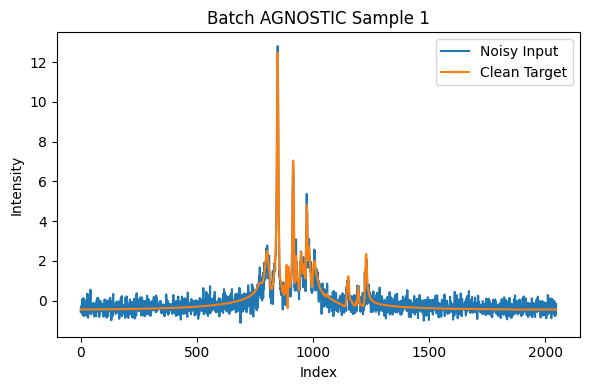

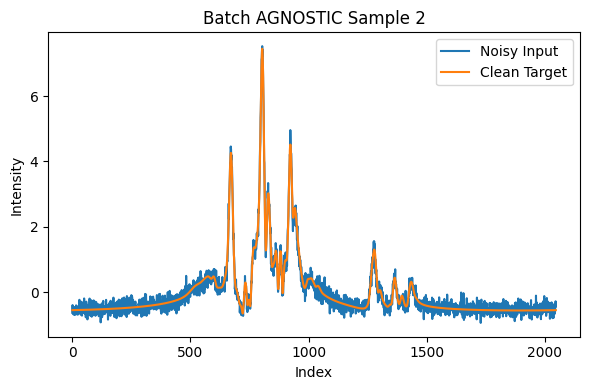

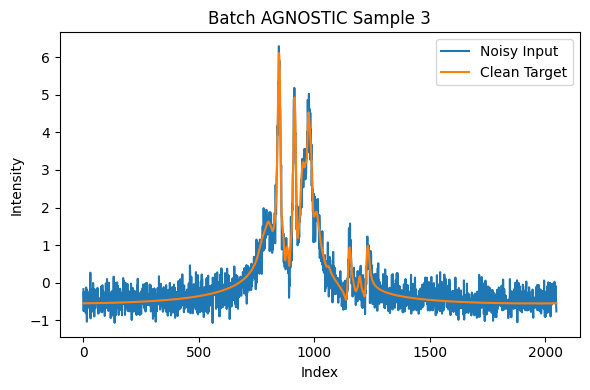

In [11]:
print("AGNOSTIC Spectra from DataLoader batch:")
noisy_batch, clean_batch = next(iter(agn_loader))
batch_pairs = list(zip(noisy_batch.numpy(), clean_batch.numpy()))
plot_spectra(batch_pairs, n=3, title_prefix="Batch AGNOSTIC Sample")

In [14]:
## Big GABA Data Class

class BigGabaDataset(Dataset):
    def __init__(self, clean_root: str, qc_df: pd.DataFrame, min_snr: float = 20.0, max_fwhm: float = 15.0, target_len: int = 2048, max_workers: int = 4):
        base = Path(clean_root) / "Big_Gaba"
        records = []
        for proc in base.rglob("*/processed.mat"):
            fit = proc.parent / "fit.mat"
            if not fit.exists(): continue
            vend, subj = proc.parts[-3], proc.parts[-2]
            row = qc_df[(qc_df.vendor == vend) & (qc_df.subject == subj)]
            if row.empty: continue
            snr = float(row.Cr_SNR.iloc[0])
            fwhm = float(row.Cr_FWHM.iloc[0])
            if snr < min_snr or fwhm > max_fwhm: continue
            records.append((proc, fit))
        if not records:
            raise RuntimeError("No scans pass QC!")
        specs_noisy, specs_clean = [], []
        with ThreadPoolExecutor(max_workers=max_workers) as exe:
            futures = {exe.submit(_load_one_gaba, p, f, target_len): (p, f) for p, f in records}
            for fut in tqdm(as_completed(futures), total=len(futures), desc="Caching Big GABA"):
                no, cl = fut.result()

                # ✅ Enforce correct shape
                if no.shape != (target_len,) or cl.shape != (target_len,):
                    print(f"⚠️ Skipping shape-mismatched sample: noisy={no.shape}, clean={cl.shape}")
                    continue

                specs_noisy.append(no)
                specs_clean.append(cl)
        self.noisy = torch.from_numpy(np.stack(specs_noisy))
        self.clean = torch.from_numpy(np.stack(specs_clean))
    def __len__(self): return self.noisy.size(0)
    def __getitem__(self, idx): return self.noisy[idx], self.clean[idx]

bg_dataset = BigGabaDataset(clean_root=str(CLEAN_ROOT), qc_df=qc_df, min_snr=8.0, max_fwhm=12.0, target_len=2048, max_workers=4)
bg_loader = DataLoader(bg_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

N = len(bg_dataset)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val  # remaining ~10%

train_ds, val_ds, test_ds = random_split(
    bg_dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

# --- 3) Create DataLoaders ---
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False,
                          num_workers=2, pin_memory=True)

Caching Big GABA: 100%|██████████| 218/218 [00:13<00:00, 15.80it/s]


Big GABA Spectra from DataLoader batch:


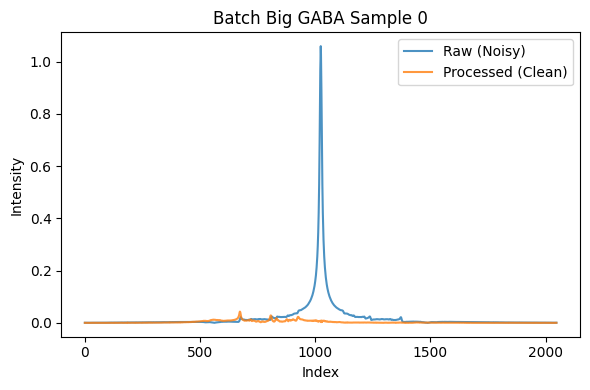

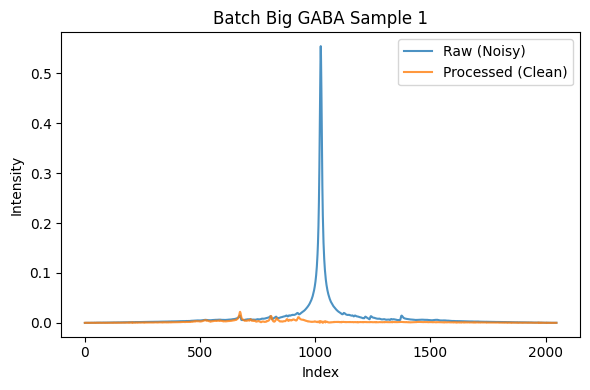

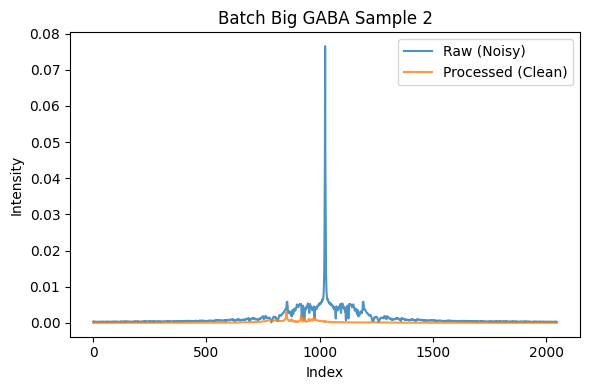

In [15]:
print("Big GABA Spectra from DataLoader batch:")

# 1) Fetch one batch
noisy_batch, clean_batch = next(iter(bg_loader))

# 2) Convert to numpy arrays
noisy_batch = noisy_batch.numpy()
clean_batch = clean_batch.numpy()

# 3) Plot overlays of raw vs clean
for i in range(min(3, len(noisy_batch))):
    plt.figure(figsize=(6, 4))
    plt.plot(noisy_batch[i], label="Raw (Noisy)", alpha=0.8)
    plt.plot(clean_batch[i], label="Processed (Clean)", alpha=0.8)
    plt.title(f"Batch Big GABA Sample {i}")
    plt.xlabel("Index")
    plt.ylabel("Intensity")
    plt.legend()
    plt.tight_layout()
    plt.show()

## **Model Architecture**

In [16]:
# Proximal Matching Loss
def proximal_matching_loss(y_pred: torch.Tensor,
                           x_true: torch.Tensor,
                           gamma: float) -> torch.Tensor:
    """
    L ≈ - E[ exp( -||f(y) - x||^2 / γ^2 ) ]
    We omit irrelevant constants.
    """
    diff2 = (y_pred - x_true).pow(2).sum(dim=1)  # (B,)
    return (- torch.exp(- diff2 / (gamma**2))).mean()

# 1D Proximal CNN (Used for POC)
class CNN1DProximal(nn.Module):
    def __init__(self, length=2048, channels=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, channels, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels, channels, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels, 1,       kernel_size=9, padding=4),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x.unsqueeze(1)).squeeze(1)

# Input Convex CNN
class ICNN1D(nn.Module):
    """
    Input‐Convex Neural Net for 1D spectra.
    The architecture:
       ψ(y) = wᵀ z2 + b0
       z1 = softplus(H1 y + b1)
       z2 = softplus(W2 z1 + H2 y + b2)
    Then prox operator f(y)=∇ψ(y) is just backprop from ψ->y.
    We implement f(y) by computing ψ and calling torch.autograd.grad(ψ.sum(), y).
    """
    def __init__(self, hidden=64, kernel=9):
        super().__init__()
        pad = kernel//2
        # cross‐connections must stay non‐negative
        self.H1 = nn.Conv1d(1, hidden, kernel, padding=pad, bias=True)
        self.W2 = nn.Conv1d(hidden, hidden, kernel, padding=pad, bias=False)
        self.H2 = nn.Conv1d(1, hidden, kernel, padding=pad, bias=True)
        self.w0 = nn.Conv1d(hidden, 1, 1, padding=0, bias=True)

        # initialize small positives
        nn.init.uniform_(self.W2.weight, 0, 0.01)
        nn.init.uniform_(self.w0.weight,  0, 0.01)

    def forward(self, y):
        """
        y: (B, L) float32
        returns prox(y) = ∇ψ(y), same shape (B,L)
        """
        # 1) ensure we can differentiate ψ w.r.t. y
        y = y.requires_grad_(True)

        # 2) build psi(y)
        y1 = y.unsqueeze(1)            # (B,1,L)
        z1 = F.softplus(self.H1(y1))   # (B,H,L)
        z2 = F.softplus(self.W2(z1) + self.H2(y1))  # (B,H,L)
        psi = self.w0(z2).squeeze(1)    # (B,L)

        # 3) now compute ∇ψ(y) with a graph
        grad_y = torch.autograd.grad(
            psi.sum(),   # scalar
            y,
            create_graph=True  # keep linkage all the way back to weights
        )[0]

        return grad_y

In [22]:
# Define model and optimizer
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = ICNN1D(hidden=64, kernel=9).to(device)
opt     = optim.Adam(model2.parameters(), lr=1e-4)
model_save_path = '/content/drive/MyDrive/ADSBME Project/MRS_Data/stage1_lpn.pth'

stage1_dir = Path("/content/drive/MyDrive/ADSBME Project/MRS_Data/Stage_1")
stage1_dir.mkdir(parents=True, exist_ok=True)

# CSV log setup
csv_path = stage1_dir / "training_log.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "avg_loss", "val_consistency", "gamma", "alpha"])

# 2) Hyperparameters
epochs        = 40
warmup        = 10
mix_ramp      = 10
gamma_start   = 5.0
gamma_floor   = 0.8
gamma_clip    = 100.0
clip_norm     = 1.0
consis_weight = 0.05  # weight on real-noisy self-consistency loss
RATIO_WARN    = 200.0

# 3) Early stopping
early_stop_patience = 5
min_delta = 1e-4
max_ratio_threshold = 60.0
best_loss = float("inf")
bad_epochs = 0
stop_epoch = None

# 4) Tracking
batch_losses = []
epoch_losses = []
gamma_vals   = []

# 5) Main training loop
real_iter = iter(train_loader)  # from BigGabaDataset (real noisy inputs)
for epoch in range(1, epochs+1):
    model2.train()
    total_loss   = 0.0
    samples_seen = 0
    ratio_list   = []

    # Gamma decay per epoch
    decay = (gamma_floor / gamma_start) ** (1 / (epochs - 1))
    gamma = max(gamma_floor, gamma_start * (decay ** (epoch - 1)))
    gamma_vals.append(gamma)

    # Mixing weight α
    alpha = 0.0 if epoch <= warmup else min(1.0, (epoch - warmup) / mix_ramp)
    print(f"Epoch {epoch}/{epochs} — γ={gamma:.3f}, α={alpha:.2f}")

    pbar = tqdm(agn_loader, desc=f"Stage1 {epoch}/{epochs}", leave=False)
    for noisy, clean in pbar:
        noisy, clean = noisy.to(device), clean.to(device)
        opt.zero_grad()

        # L2 normalize predictions and clean targets before loss
        pred = model2(noisy)

        # Compute scale-invariant losses
        mse  = F.mse_loss(pred, clean)

        diff2 = (pred - clean).pow(2).sum(dim=1)
        prox = - torch.exp(-diff2 / (gamma ** 2)).mean()

        ratio = (diff2.double() / (gamma ** 2)).clamp(max=gamma_clip)
        ratio_list.append(ratio)
        max_ratio = ratio.max().item()

        loss = (1 - alpha) * mse + alpha * prox

        # Update
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), clip_norm)
        opt.step()

        batch_losses.append(loss.item())
        total_loss += loss.item() * noisy.size(0)
        samples_seen += noisy.size(0)

        pbar.set_postfix(loss=f"{loss.item():.3e}", max_ratio=f"{max_ratio:.1e}")

    avg_loss = total_loss / samples_seen
    epoch_losses.append(avg_loss)
    all_ratios = torch.cat(ratio_list)
    p90        = all_ratios.kthvalue(int(0.9 * len(all_ratios)))[0]
    mean_r     = all_ratios.mean().item()

    model2.eval()
    val_consis_losses = []
    for y_val, _ in val_loader:
        y_val = y_val.to(device)
        f_val = model2(y_val)
        val_consis = F.mse_loss(l2_normalize(f_val), l2_normalize(y_val))
        val_consis_losses.append(val_consis.item())

    mean_val_consis = np.mean(val_consis_losses)
    print(f"Validation self-consistency loss: {mean_val_consis:.4e}")

    with open(csv_path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, avg_loss, mean_val_consis, gamma, alpha])

    print(
        f"Epoch {epoch}: avg_loss={avg_loss:.3e}, val_self_con_loss={mean_val_consis:.4e}, ratio mean={mean_r:.1e}, "
        f"p90={p90:.1e}, max={all_ratios.max().item():.1e}"
    )
    if mean_r > RATIO_WARN:
        print(f"Warning: high ratio mean={mean_r:.1e} — consider longer warmup or higher γ")

    # Early stopping
    if alpha < 1.0:
        improved = avg_loss < best_loss - min_delta
    else:
        improved = avg_loss > best_loss + min_delta  # Since loss is negative, going toward 0 is better

    if improved:
        best_loss = avg_loss
        bad_epochs = 0
        torch.save(model2.state_dict(), model_save_path)
        print("New best model saved.")
    else:
        bad_epochs += 1

    if mean_r > max_ratio_threshold:
        print(f"Early stopping: ratio mean {mean_r:.1f} exceeds threshold {max_ratio_threshold}")
        stop_epoch = epoch
        break

    if bad_epochs >= early_stop_patience:
        print(f"Early stopping: no improvement for {early_stop_patience} epochs")
        stop_epoch = epoch
        break

    # Visualization: f(y) vs y vs x
    if epoch % 5 == 0:
        model2.eval()
        y, x = next(iter(agn_loader))
        y, x = y.to(device)[:1], x.to(device)[:1]
        y.requires_grad_(True)
        fy = model2(y)
        plt.figure(figsize=(12, 4))
        plt.plot(y[0].detach().cpu(), label="Input y")
        plt.plot(fy[0].detach().cpu(), label="f(y)", alpha=0.8)
        plt.plot(x[0].detach().cpu(), label="Clean x", linestyle="--")
        plt.legend()
        plt.title(f"Epoch {epoch}: Proximal Mapping")
        plt.tight_layout()
        plt.savefig(stage1_dir / f"prox_mapping_epoch_{epoch}.png")
        plt.close()

if stop_epoch:
    print(f"Training stopped early at epoch {stop_epoch}")
else:
    print("Training completed all epochs.")

# Final training plots
plt.figure()
plt.plot(epoch_losses)
plt.title("Stage 1: Avg Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig(stage1_dir / "avg_loss_curve.png")
plt.close()

plt.figure()
plt.plot(batch_losses)
plt.title("Stage 1: Loss per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig(stage1_dir / "batch_loss_curve.png")
plt.close()

plt.figure()
plt.plot(gamma_vals)
plt.title("Gamma Decay Schedule")
plt.xlabel("Epoch")
plt.ylabel("Gamma")
plt.grid(True)
plt.tight_layout()
plt.savefig(stage1_dir / "gamma_schedule.png")
plt.close()


Epoch 1/40 — γ=5.000, α=0.00


Validation self-consistency loss: 5.4433e-04
Epoch 1: avg_loss=1.830e-01, val_self_con_loss=5.4433e-04, ratio mean=1.5e+01, p90=4.6e+01, max=8.6e+01
New best model saved.
Epoch 2/40 — γ=4.770, α=0.00


Validation self-consistency loss: 3.9940e-04
Epoch 2: avg_loss=5.352e-02, val_self_con_loss=3.9940e-04, ratio mean=4.8e+00, p90=1.3e+01, max=7.9e+01
New best model saved.
Epoch 3/40 — γ=4.552, α=0.00


Validation self-consistency loss: 3.1969e-04
Epoch 3: avg_loss=4.222e-02, val_self_con_loss=3.1969e-04, ratio mean=4.2e+00, p90=1.0e+01, max=8.5e+01
New best model saved.
Epoch 4/40 — γ=4.343, α=0.00


Validation self-consistency loss: 4.5406e-04
Epoch 4: avg_loss=3.832e-02, val_self_con_loss=4.5406e-04, ratio mean=4.2e+00, p90=9.7e+00, max=9.2e+01
New best model saved.
Epoch 5/40 — γ=4.143, α=0.00


Validation self-consistency loss: 3.5176e-04
Epoch 5: avg_loss=3.660e-02, val_self_con_loss=3.5176e-04, ratio mean=4.4e+00, p90=9.9e+00, max=1.0e+02
New best model saved.
Epoch 6/40 — γ=3.953, α=0.00


Validation self-consistency loss: 3.6873e-04
Epoch 6: avg_loss=3.569e-02, val_self_con_loss=3.6873e-04, ratio mean=4.7e+00, p90=1.0e+01, max=1.0e+02
New best model saved.
Epoch 7/40 — γ=3.772, α=0.00


Validation self-consistency loss: 3.9633e-04
Epoch 7: avg_loss=3.512e-02, val_self_con_loss=3.9633e-04, ratio mean=5.1e+00, p90=1.1e+01, max=1.0e+02
New best model saved.
Epoch 8/40 — γ=3.598, α=0.00


Validation self-consistency loss: 3.1964e-04
Epoch 8: avg_loss=3.470e-02, val_self_con_loss=3.1964e-04, ratio mean=5.5e+00, p90=1.2e+01, max=1.0e+02
New best model saved.
Epoch 9/40 — γ=3.433, α=0.00


Validation self-consistency loss: 3.6396e-04
Epoch 9: avg_loss=3.439e-02, val_self_con_loss=3.6396e-04, ratio mean=6.0e+00, p90=1.3e+01, max=1.0e+02
New best model saved.
Epoch 10/40 — γ=3.276, α=0.00


Validation self-consistency loss: 3.2450e-04
Epoch 10: avg_loss=3.415e-02, val_self_con_loss=3.2450e-04, ratio mean=6.5e+00, p90=1.4e+01, max=1.0e+02
New best model saved.
Epoch 11/40 — γ=3.125, α=0.10


Validation self-consistency loss: 2.9569e-04
Epoch 11: avg_loss=5.878e-03, val_self_con_loss=2.9569e-04, ratio mean=7.5e+00, p90=1.9e+01, max=1.0e+02
New best model saved.
Epoch 12/40 — γ=2.982, α=0.20


Validation self-consistency loss: 2.9001e-04
Epoch 12: avg_loss=-2.424e-02, val_self_con_loss=2.9001e-04, ratio mean=8.4e+00, p90=2.2e+01, max=1.0e+02
New best model saved.
Epoch 13/40 — γ=2.845, α=0.30


Validation self-consistency loss: 2.8527e-04
Epoch 13: avg_loss=-5.219e-02, val_self_con_loss=2.8527e-04, ratio mean=9.4e+00, p90=2.6e+01, max=1.0e+02
New best model saved.
Epoch 14/40 — γ=2.714, α=0.40


Validation self-consistency loss: 2.8246e-04
Epoch 14: avg_loss=-7.713e-02, val_self_con_loss=2.8246e-04, ratio mean=1.0e+01, p90=2.9e+01, max=1.0e+02
New best model saved.
Epoch 15/40 — γ=2.590, α=0.50


Validation self-consistency loss: 2.8413e-04
Epoch 15: avg_loss=-9.924e-02, val_self_con_loss=2.8413e-04, ratio mean=1.1e+01, p90=3.4e+01, max=1.0e+02
New best model saved.
Epoch 16/40 — γ=2.471, α=0.60


Validation self-consistency loss: 2.8024e-04
Epoch 16: avg_loss=-1.185e-01, val_self_con_loss=2.8024e-04, ratio mean=1.2e+01, p90=3.8e+01, max=1.0e+02
New best model saved.
Epoch 17/40 — γ=2.358, α=0.70


Validation self-consistency loss: 2.8243e-04
Epoch 17: avg_loss=-1.352e-01, val_self_con_loss=2.8243e-04, ratio mean=1.3e+01, p90=4.3e+01, max=1.0e+02
New best model saved.
Epoch 18/40 — γ=2.249, α=0.80


Validation self-consistency loss: 2.8484e-04
Epoch 18: avg_loss=-1.491e-01, val_self_con_loss=2.8484e-04, ratio mean=1.4e+01, p90=4.8e+01, max=1.0e+02
New best model saved.
Epoch 19/40 — γ=2.146, α=0.90


Validation self-consistency loss: 2.7941e-04
Epoch 19: avg_loss=-1.611e-01, val_self_con_loss=2.7941e-04, ratio mean=1.5e+01, p90=5.4e+01, max=1.0e+02
New best model saved.
Epoch 20/40 — γ=2.048, α=1.00


Validation self-consistency loss: 2.8306e-04
Epoch 20: avg_loss=-1.707e-01, val_self_con_loss=2.8306e-04, ratio mean=1.6e+01, p90=6.2e+01, max=1.0e+02
Epoch 21/40 — γ=1.954, α=1.00


Validation self-consistency loss: 2.7894e-04
Epoch 21: avg_loss=-1.578e-01, val_self_con_loss=2.7894e-04, ratio mean=1.7e+01, p90=7.0e+01, max=1.0e+02
New best model saved.
Epoch 22/40 — γ=1.864, α=1.00


Validation self-consistency loss: 2.7961e-04
Epoch 22: avg_loss=-1.455e-01, val_self_con_loss=2.7961e-04, ratio mean=1.8e+01, p90=8.0e+01, max=1.0e+02
New best model saved.
Epoch 23/40 — γ=1.778, α=1.00


Validation self-consistency loss: 2.8254e-04
Epoch 23: avg_loss=-1.338e-01, val_self_con_loss=2.8254e-04, ratio mean=2.0e+01, p90=9.1e+01, max=1.0e+02
New best model saved.
Epoch 24/40 — γ=1.697, α=1.00


Validation self-consistency loss: 2.8102e-04
Epoch 24: avg_loss=-1.224e-01, val_self_con_loss=2.8102e-04, ratio mean=2.1e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 25/40 — γ=1.619, α=1.00


Validation self-consistency loss: 2.8273e-04
Epoch 25: avg_loss=-1.117e-01, val_self_con_loss=2.8273e-04, ratio mean=2.2e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 26/40 — γ=1.545, α=1.00


Validation self-consistency loss: 2.8239e-04
Epoch 26: avg_loss=-1.013e-01, val_self_con_loss=2.8239e-04, ratio mean=2.3e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 27/40 — γ=1.474, α=1.00


Validation self-consistency loss: 2.8213e-04
Epoch 27: avg_loss=-9.122e-02, val_self_con_loss=2.8213e-04, ratio mean=2.4e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 28/40 — γ=1.406, α=1.00


Validation self-consistency loss: 2.9450e-04
Epoch 28: avg_loss=-8.242e-02, val_self_con_loss=2.9450e-04, ratio mean=2.6e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 29/40 — γ=1.341, α=1.00


Validation self-consistency loss: 2.8471e-04
Epoch 29: avg_loss=-7.355e-02, val_self_con_loss=2.8471e-04, ratio mean=2.7e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 30/40 — γ=1.280, α=1.00


Validation self-consistency loss: 2.8478e-04
Epoch 30: avg_loss=-6.552e-02, val_self_con_loss=2.8478e-04, ratio mean=2.8e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 31/40 — γ=1.221, α=1.00


Validation self-consistency loss: 2.8655e-04
Epoch 31: avg_loss=-5.838e-02, val_self_con_loss=2.8655e-04, ratio mean=2.9e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 32/40 — γ=1.165, α=1.00


Validation self-consistency loss: 2.8764e-04
Epoch 32: avg_loss=-5.144e-02, val_self_con_loss=2.8764e-04, ratio mean=3.1e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 33/40 — γ=1.112, α=1.00


Validation self-consistency loss: 2.9230e-04
Epoch 33: avg_loss=-4.532e-02, val_self_con_loss=2.9230e-04, ratio mean=3.2e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 34/40 — γ=1.061, α=1.00


Validation self-consistency loss: 2.9050e-04
Epoch 34: avg_loss=-3.948e-02, val_self_con_loss=2.9050e-04, ratio mean=3.4e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 35/40 — γ=1.012, α=1.00


Validation self-consistency loss: 3.0015e-04
Epoch 35: avg_loss=-3.426e-02, val_self_con_loss=3.0015e-04, ratio mean=3.5e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 36/40 — γ=0.965, α=1.00


Validation self-consistency loss: 2.8763e-04
Epoch 36: avg_loss=-2.973e-02, val_self_con_loss=2.8763e-04, ratio mean=3.6e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 37/40 — γ=0.921, α=1.00


Validation self-consistency loss: 2.9413e-04
Epoch 37: avg_loss=-2.517e-02, val_self_con_loss=2.9413e-04, ratio mean=3.8e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 38/40 — γ=0.879, α=1.00


Validation self-consistency loss: 3.3582e-04
Epoch 38: avg_loss=-2.154e-02, val_self_con_loss=3.3582e-04, ratio mean=4.0e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 39/40 — γ=0.838, α=1.00


Validation self-consistency loss: 2.9766e-04
Epoch 39: avg_loss=-1.822e-02, val_self_con_loss=2.9766e-04, ratio mean=4.1e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Epoch 40/40 — γ=0.800, α=1.00


Validation self-consistency loss: 2.9986e-04
Epoch 40: avg_loss=-1.559e-02, val_self_con_loss=2.9986e-04, ratio mean=4.3e+01, p90=1.0e+02, max=1.0e+02
New best model saved.
Training completed all epochs.


In [23]:
model2.eval()
mse_sum = 0.0
count = 0
for y, x in agn_loader:
    y = y.to(device).requires_grad_(True)
    x = x.to(device)
    #with torch.no_grad():
    pred = model2(y)
    mse_sum += F.mse_loss(pred.detach(), x, reduction="sum").item()
    count += y.size(0)
avg_mse = mse_sum / count
print(f"Stage1 AGN MSE on synthetic data: {avg_mse:.3e}")


Stage1 AGN MSE on synthetic data: 1.195e+02


Stage 1 Evaluation — Test MSE: 1.697351, PSNR: 16.46 dB


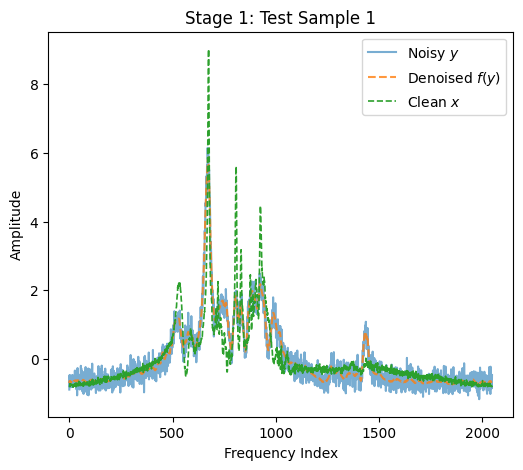

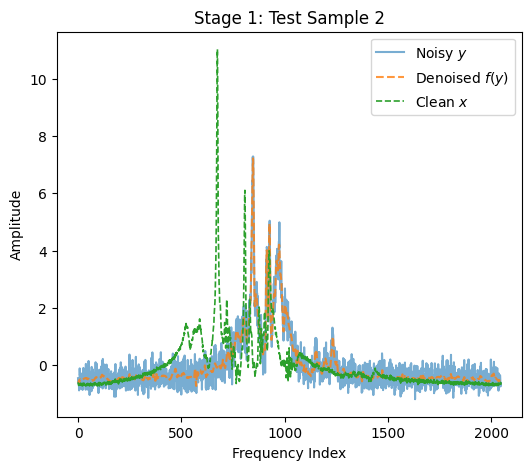

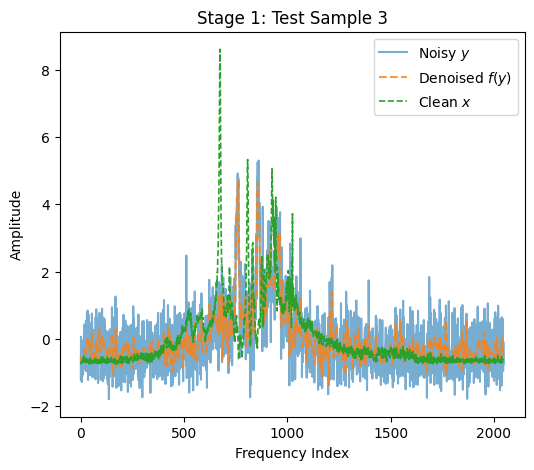

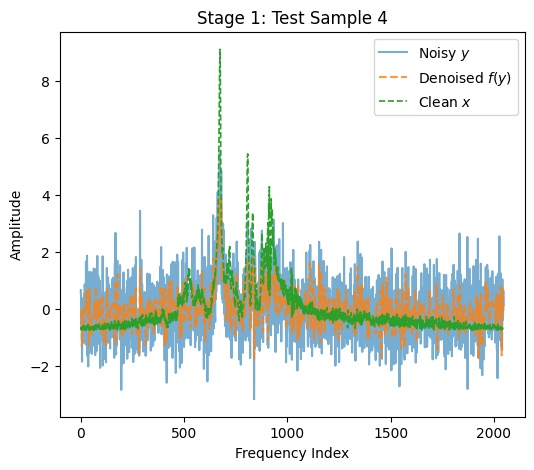

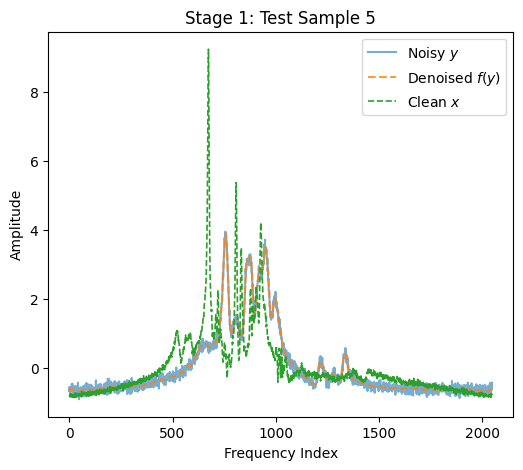

In [32]:
model2 = ICNN1D(hidden=64, kernel=9).to(device)
model2.load_state_dict(torch.load(model_save_path))
model2 = model2.to(device)

def zscore_tensor(x):
    return (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-8)

# Evaluation loop for Stage 1
model2.eval()
mse_sum = 0.0
psnr_sum = 0.0
n_samples = 0

for raw, clean in tqdm(test_loader, desc="Evaluating Stage 1", leave=False):
    raw, clean = raw.to(device), clean.to(device)

    # Normalize input only for evaluation
    raw = l2_normalize(raw)
    clean = l2_normalize(clean)

    pred = model2(raw)

    mse_sum += nn.MSELoss(reduction="sum")(pred, clean).item()

    raw_np   = raw.cpu().detach().numpy()
    clean_np = clean.cpu().detach().numpy()
    pred_np  = pred.cpu().detach().numpy()
    for j in range(raw_np.shape[0]):
        dr = clean_np[j].max() - clean_np[j].min()
        psnr_sum += psnr(clean_np[j], pred_np[j], data_range=dr)

    n_samples += raw_np.shape[0]

test_mse = mse_sum / n_samples
avg_psnr = psnr_sum / n_samples

print(f"Stage 1 Evaluation — Test MSE: {test_mse:.6f}, PSNR: {avg_psnr:.2f} dB")

model2.eval()
n_plots = 5  # number of examples to visualize

for raw, clean in test_loader:
    raw, clean = noisy.to(device), clean.to(device)
    raw_zscore = zscore_tensor(raw)
    clean_zscore = zscore_tensor(clean)
    pred = model2(raw_zscore)
    break  # we just need the first batch

raw_np = raw_zscore.cpu().detach().numpy()
clean_np = clean_zscore.cpu().detach().numpy()
pred_np  = pred.cpu().detach().numpy()

for i in range(n_plots):
    plt.figure(figsize=(6,5))
    plt.plot(raw_np[i], label="Noisy $y$", alpha=0.6)
    plt.plot(pred_np[i],  label="Denoised $f(y)$", linestyle="--", alpha=0.8)
    plt.plot(clean_np[i], label="Clean $x$", linestyle="--", linewidth=1.2)
    plt.title(f"Stage 1: Test Sample {i+1}")
    plt.xlabel("Frequency Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [37]:
# 1) Load pretrained Stage 1 weights
model2 = ICNN1D(hidden=64, kernel=9).to(device)
model2.load_state_dict(torch.load(model_save_path))
model2 = model2.to(device)
model2.train()

model_2_save_path = '/content/drive/MyDrive/ADSBME Project/MRS_Data/stage2_lpn.pth'
stage2_dir = Path("/content/drive/MyDrive/ADSBME Project/MRS_Data/Stage_2")
stage2_dir.mkdir(parents=True, exist_ok=True)

# CSV log setup
csv_path = stage2_dir / "training_log.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_mse", "val_mse", "val_psnr"])

# 2) Optimizer + AMP scaler
optimizer = optim.Adam(model2.parameters(), lr=1e-4)
scaler    = GradScaler()

# 3) Fine-tuning loop with tracking, early stopping, visualization
n_epochs = 200
patience = 10
min_delta = 1e-4
no_improve = 0
best_val_mse = float("inf")

train_losses = []
val_losses = []
psnr_scores = []

for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    model2.train()
    pbar = tqdm(train_loader, desc=f"Stage2 Epoch {epoch}/{n_epochs}", leave=False)

    for raw_spec, clean_spec in pbar:
        raw_spec   = l2_normalize(raw_spec.to(device, non_blocking=True))
        clean_spec = l2_normalize(clean_spec.to(device, non_blocking=True))

        optimizer.zero_grad()
        with autocast("cuda"):
            pred = model2(raw_spec)

            # Compute normalized MSE loss
            loss_fn = nn.MSELoss(reduction="mean")
            loss = loss_fn(pred, clean_spec)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * raw_spec.size(0)
        pbar.set_postfix(mse=f"{loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    tqdm.write(f"[Stage2] Epoch {epoch:02d}/{n_epochs} — Avg MSE {avg_train_loss:.6f}")

    # Validation
    model2.eval()
    mse_sum = 0.0
    psnr_sum = 0.0
    n_samples = 0

    for raw, clean in tqdm(val_loader, desc="Validating", leave=False):
        raw = l2_normalize(raw.to(device))
        clean = l2_normalize(clean.to(device))
        pred = model2(raw)

        mse_sum += nn.MSELoss(reduction="sum")(l2_normalize(pred), clean).item()

        raw_np   = raw.cpu().detach().numpy()
        clean_np = clean.cpu().detach().numpy()
        pred_np  = pred.cpu().detach().numpy()
        for j in range(raw_np.shape[0]):
            dr = clean_np[j].max() - clean_np[j].min()
            psnr_sum += psnr(clean_np[j], pred_np[j], data_range=dr)

        n_samples += raw_np.shape[0]

    val_mse = mse_sum / n_samples
    val_psnr = psnr_sum / n_samples
    val_losses.append(val_mse)
    psnr_scores.append(val_psnr)
    tqdm.write(f"[Stage2] Epoch {epoch:02d} — Val MSE: {val_mse:.6f}, PSNR: {val_psnr:.2f} dB")

    # Log metrics to CSV
    with open(csv_path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, avg_train_loss, val_mse, val_psnr])

    if val_mse < best_val_mse - min_delta:
        best_val_mse = val_mse
        torch.save(model2.state_dict(), model_2_save_path)
        tqdm.write(f"Best model saved at epoch {epoch} with Val MSE: {val_mse:.6f}")
        no_improve = 0
    else:
        no_improve += 1

    # Visualize predictions
    if epoch % 10 == 0:
        y, x = next(iter(val_loader))
        y = l2_normalize(y.to(device)[:1])
        x = l2_normalize(x.to(device)[:1])
        fy = model2(y)

        fig = plt.figure(figsize=(12, 4))
        plt.plot(y[0].cpu().detach().numpy(), label="Input y")
        plt.plot(fy[0].cpu().detach().numpy(), label="f(y)", alpha=0.8)
        plt.plot(x[0].cpu().detach().numpy(), label="Clean x", linestyle="--")
        plt.legend(); plt.title(f"Epoch {epoch}: Proximal Mapping")
        plt.tight_layout()
        plt.savefig(stage2_dir / f"prox_mapping_epoch_{epoch}.png")
        plt.close(fig)

        # Residual plot
        residual = (fy - x).squeeze(0).cpu().detach().numpy()
        fig = plt.figure(figsize=(12, 3))
        plt.plot(residual, label="Residual f(y) - x")
        plt.axhline(0, color="gray", linestyle="--")
        plt.title(f"Epoch {epoch}: Residual Plot")
        plt.xlabel("Index")
        plt.ylabel("Residual")
        plt.legend()
        plt.tight_layout()
        plt.savefig(stage2_dir / f"residual_epoch_{epoch}.png")
        plt.close(fig)

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch} — no improvement for {patience} epochs")
        break

# 4) Plotting curves
plt.figure(); plt.plot(train_losses); plt.title("Stage 2: Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Train MSE"); plt.grid(True); plt.tight_layout(); plt.savefig(stage2_dir / "train_loss_curve.png"); plt.close()
plt.figure(); plt.plot(val_losses); plt.title("Stage 2: Validation Loss"); plt.xlabel("Epoch"); plt.ylabel("Val MSE"); plt.grid(True); plt.tight_layout(); plt.savefig(stage2_dir / "val_loss_curve.png"); plt.close()
plt.figure(); plt.plot(psnr_scores); plt.title("Stage 2: PSNR per Epoch"); plt.xlabel("Epoch"); plt.ylabel("PSNR (dB)"); plt.grid(True); plt.tight_layout(); plt.savefig(stage2_dir / "psnr_curve.png"); plt.close()


[Stage2] Epoch 01/200 — Avg MSE 0.001013


[Stage2] Epoch 01 — Val MSE: 1.520728, PSNR: 16.87 dB
Best model saved at epoch 1 with Val MSE: 1.520728


[Stage2] Epoch 02/200 — Avg MSE 0.000796


[Stage2] Epoch 02 — Val MSE: 1.424056, PSNR: 17.29 dB
Best model saved at epoch 2 with Val MSE: 1.424056


[Stage2] Epoch 03/200 — Avg MSE 0.000715


[Stage2] Epoch 03 — Val MSE: 1.287884, PSNR: 17.73 dB
Best model saved at epoch 3 with Val MSE: 1.287884


[Stage2] Epoch 04/200 — Avg MSE 0.000664


[Stage2] Epoch 04 — Val MSE: 1.225327, PSNR: 18.02 dB
Best model saved at epoch 4 with Val MSE: 1.225327


[Stage2] Epoch 05/200 — Avg MSE 0.000626


[Stage2] Epoch 05 — Val MSE: 1.172909, PSNR: 18.27 dB
Best model saved at epoch 5 with Val MSE: 1.172909


[Stage2] Epoch 06/200 — Avg MSE 0.000592


[Stage2] Epoch 06 — Val MSE: 1.121235, PSNR: 18.48 dB
Best model saved at epoch 6 with Val MSE: 1.121235


[Stage2] Epoch 07/200 — Avg MSE 0.000563


[Stage2] Epoch 07 — Val MSE: 1.103047, PSNR: 18.69 dB
Best model saved at epoch 7 with Val MSE: 1.103047


[Stage2] Epoch 08/200 — Avg MSE 0.000538


[Stage2] Epoch 08 — Val MSE: 1.090856, PSNR: 18.90 dB
Best model saved at epoch 8 with Val MSE: 1.090856


[Stage2] Epoch 09/200 — Avg MSE 0.000512


[Stage2] Epoch 09 — Val MSE: 1.035728, PSNR: 19.11 dB
Best model saved at epoch 9 with Val MSE: 1.035728


[Stage2] Epoch 10/200 — Avg MSE 0.000486


[Stage2] Epoch 10 — Val MSE: 1.019320, PSNR: 19.37 dB
Best model saved at epoch 10 with Val MSE: 1.019320


[Stage2] Epoch 11/200 — Avg MSE 0.000456


[Stage2] Epoch 11 — Val MSE: 1.001297, PSNR: 19.67 dB
Best model saved at epoch 11 with Val MSE: 1.001297


[Stage2] Epoch 12/200 — Avg MSE 0.000426


[Stage2] Epoch 12 — Val MSE: 0.966719, PSNR: 19.95 dB
Best model saved at epoch 12 with Val MSE: 0.966719


[Stage2] Epoch 13/200 — Avg MSE 0.000402


[Stage2] Epoch 13 — Val MSE: 0.918971, PSNR: 20.16 dB
Best model saved at epoch 13 with Val MSE: 0.918971


[Stage2] Epoch 14/200 — Avg MSE 0.000385


[Stage2] Epoch 14 — Val MSE: 0.905282, PSNR: 20.33 dB
Best model saved at epoch 14 with Val MSE: 0.905282


[Stage2] Epoch 15/200 — Avg MSE 0.000372


[Stage2] Epoch 15 — Val MSE: 0.926888, PSNR: 20.45 dB


[Stage2] Epoch 16/200 — Avg MSE 0.000363


[Stage2] Epoch 16 — Val MSE: 0.865404, PSNR: 20.54 dB
Best model saved at epoch 16 with Val MSE: 0.865404


[Stage2] Epoch 17/200 — Avg MSE 0.000354


[Stage2] Epoch 17 — Val MSE: 0.885838, PSNR: 20.64 dB


[Stage2] Epoch 18/200 — Avg MSE 0.000349


[Stage2] Epoch 18 — Val MSE: 0.845241, PSNR: 20.69 dB
Best model saved at epoch 18 with Val MSE: 0.845241


[Stage2] Epoch 19/200 — Avg MSE 0.000342


[Stage2] Epoch 19 — Val MSE: 0.838739, PSNR: 20.77 dB
Best model saved at epoch 19 with Val MSE: 0.838739


[Stage2] Epoch 20/200 — Avg MSE 0.000338


[Stage2] Epoch 20 — Val MSE: 0.849005, PSNR: 20.83 dB


[Stage2] Epoch 21/200 — Avg MSE 0.000334


[Stage2] Epoch 21 — Val MSE: 0.817367, PSNR: 20.85 dB
Best model saved at epoch 21 with Val MSE: 0.817367


[Stage2] Epoch 22/200 — Avg MSE 0.000331


[Stage2] Epoch 22 — Val MSE: 0.842746, PSNR: 20.90 dB


[Stage2] Epoch 23/200 — Avg MSE 0.000328


[Stage2] Epoch 23 — Val MSE: 0.815085, PSNR: 20.94 dB
Best model saved at epoch 23 with Val MSE: 0.815085


[Stage2] Epoch 24/200 — Avg MSE 0.000326


[Stage2] Epoch 24 — Val MSE: 0.825258, PSNR: 20.97 dB


[Stage2] Epoch 25/200 — Avg MSE 0.000323


[Stage2] Epoch 25 — Val MSE: 0.804474, PSNR: 21.01 dB
Best model saved at epoch 25 with Val MSE: 0.804474


[Stage2] Epoch 26/200 — Avg MSE 0.000323


[Stage2] Epoch 26 — Val MSE: 0.792829, PSNR: 20.99 dB
Best model saved at epoch 26 with Val MSE: 0.792829


[Stage2] Epoch 27/200 — Avg MSE 0.000322


[Stage2] Epoch 27 — Val MSE: 0.827241, PSNR: 20.99 dB


[Stage2] Epoch 28/200 — Avg MSE 0.000322


[Stage2] Epoch 28 — Val MSE: 0.802248, PSNR: 21.05 dB


[Stage2] Epoch 29/200 — Avg MSE 0.000318


[Stage2] Epoch 29 — Val MSE: 0.802391, PSNR: 21.07 dB


[Stage2] Epoch 30/200 — Avg MSE 0.000316


[Stage2] Epoch 30 — Val MSE: 0.791902, PSNR: 21.10 dB
Best model saved at epoch 30 with Val MSE: 0.791902


[Stage2] Epoch 31/200 — Avg MSE 0.000315


[Stage2] Epoch 31 — Val MSE: 0.789109, PSNR: 21.08 dB
Best model saved at epoch 31 with Val MSE: 0.789109


[Stage2] Epoch 32/200 — Avg MSE 0.000314


[Stage2] Epoch 32 — Val MSE: 0.793463, PSNR: 21.11 dB


[Stage2] Epoch 33/200 — Avg MSE 0.000314


[Stage2] Epoch 33 — Val MSE: 0.786969, PSNR: 21.13 dB
Best model saved at epoch 33 with Val MSE: 0.786969


[Stage2] Epoch 34/200 — Avg MSE 0.000313


[Stage2] Epoch 34 — Val MSE: 0.784139, PSNR: 21.11 dB
Best model saved at epoch 34 with Val MSE: 0.784139


[Stage2] Epoch 35/200 — Avg MSE 0.000313


[Stage2] Epoch 35 — Val MSE: 0.781141, PSNR: 21.15 dB
Best model saved at epoch 35 with Val MSE: 0.781141


[Stage2] Epoch 36/200 — Avg MSE 0.000313


[Stage2] Epoch 36 — Val MSE: 0.781610, PSNR: 21.14 dB


[Stage2] Epoch 37/200 — Avg MSE 0.000312


[Stage2] Epoch 37 — Val MSE: 0.776441, PSNR: 21.16 dB
Best model saved at epoch 37 with Val MSE: 0.776441


[Stage2] Epoch 38/200 — Avg MSE 0.000312


[Stage2] Epoch 38 — Val MSE: 0.782049, PSNR: 21.15 dB


[Stage2] Epoch 39/200 — Avg MSE 0.000311


[Stage2] Epoch 39 — Val MSE: 0.775322, PSNR: 21.19 dB
Best model saved at epoch 39 with Val MSE: 0.775322


[Stage2] Epoch 40/200 — Avg MSE 0.000309


[Stage2] Epoch 40 — Val MSE: 0.786327, PSNR: 21.14 dB


[Stage2] Epoch 41/200 — Avg MSE 0.000309


[Stage2] Epoch 41 — Val MSE: 0.778973, PSNR: 21.18 dB


[Stage2] Epoch 42/200 — Avg MSE 0.000309


[Stage2] Epoch 42 — Val MSE: 0.775582, PSNR: 21.19 dB


[Stage2] Epoch 43/200 — Avg MSE 0.000309


[Stage2] Epoch 43 — Val MSE: 0.774240, PSNR: 21.16 dB
Best model saved at epoch 43 with Val MSE: 0.774240


[Stage2] Epoch 44/200 — Avg MSE 0.000308


[Stage2] Epoch 44 — Val MSE: 0.770428, PSNR: 21.15 dB
Best model saved at epoch 44 with Val MSE: 0.770428


[Stage2] Epoch 45/200 — Avg MSE 0.000310


[Stage2] Epoch 45 — Val MSE: 0.771104, PSNR: 21.20 dB


[Stage2] Epoch 46/200 — Avg MSE 0.000309


[Stage2] Epoch 46 — Val MSE: 0.770712, PSNR: 21.19 dB


[Stage2] Epoch 47/200 — Avg MSE 0.000308


[Stage2] Epoch 47 — Val MSE: 0.772768, PSNR: 21.20 dB


[Stage2] Epoch 48/200 — Avg MSE 0.000308


[Stage2] Epoch 48 — Val MSE: 0.768461, PSNR: 21.21 dB
Best model saved at epoch 48 with Val MSE: 0.768461


[Stage2] Epoch 49/200 — Avg MSE 0.000309


[Stage2] Epoch 49 — Val MSE: 0.771417, PSNR: 21.21 dB


[Stage2] Epoch 50/200 — Avg MSE 0.000309


[Stage2] Epoch 50 — Val MSE: 0.773256, PSNR: 21.19 dB


[Stage2] Epoch 51/200 — Avg MSE 0.000308


[Stage2] Epoch 51 — Val MSE: 0.769182, PSNR: 21.21 dB


[Stage2] Epoch 52/200 — Avg MSE 0.000307


[Stage2] Epoch 52 — Val MSE: 0.770961, PSNR: 21.21 dB


[Stage2] Epoch 53/200 — Avg MSE 0.000307


[Stage2] Epoch 53 — Val MSE: 0.768113, PSNR: 21.20 dB
Best model saved at epoch 53 with Val MSE: 0.768113


[Stage2] Epoch 54/200 — Avg MSE 0.000308


[Stage2] Epoch 54 — Val MSE: 0.767250, PSNR: 21.22 dB
Best model saved at epoch 54 with Val MSE: 0.767250


[Stage2] Epoch 55/200 — Avg MSE 0.000309


[Stage2] Epoch 55 — Val MSE: 0.769288, PSNR: 21.21 dB


[Stage2] Epoch 56/200 — Avg MSE 0.000309


[Stage2] Epoch 56 — Val MSE: 0.766920, PSNR: 21.22 dB
Best model saved at epoch 56 with Val MSE: 0.766920


[Stage2] Epoch 57/200 — Avg MSE 0.000309


[Stage2] Epoch 57 — Val MSE: 0.767095, PSNR: 21.22 dB


[Stage2] Epoch 58/200 — Avg MSE 0.000309


[Stage2] Epoch 58 — Val MSE: 0.765738, PSNR: 21.23 dB
Best model saved at epoch 58 with Val MSE: 0.765738


[Stage2] Epoch 59/200 — Avg MSE 0.000307


[Stage2] Epoch 59 — Val MSE: 0.768771, PSNR: 21.20 dB


[Stage2] Epoch 60/200 — Avg MSE 0.000306


[Stage2] Epoch 60 — Val MSE: 0.768364, PSNR: 21.22 dB


[Stage2] Epoch 61/200 — Avg MSE 0.000306


[Stage2] Epoch 61 — Val MSE: 0.766268, PSNR: 21.23 dB


[Stage2] Epoch 62/200 — Avg MSE 0.000307


[Stage2] Epoch 62 — Val MSE: 0.764092, PSNR: 21.24 dB
Best model saved at epoch 62 with Val MSE: 0.764092


[Stage2] Epoch 63/200 — Avg MSE 0.000307


[Stage2] Epoch 63 — Val MSE: 0.765111, PSNR: 21.23 dB


[Stage2] Epoch 64/200 — Avg MSE 0.000308


[Stage2] Epoch 64 — Val MSE: 0.764894, PSNR: 21.24 dB


[Stage2] Epoch 65/200 — Avg MSE 0.000307


[Stage2] Epoch 65 — Val MSE: 0.768605, PSNR: 21.20 dB


[Stage2] Epoch 66/200 — Avg MSE 0.000307


[Stage2] Epoch 66 — Val MSE: 0.768025, PSNR: 21.20 dB


[Stage2] Epoch 67/200 — Avg MSE 0.000306


[Stage2] Epoch 67 — Val MSE: 0.766784, PSNR: 21.22 dB


[Stage2] Epoch 68/200 — Avg MSE 0.000306


[Stage2] Epoch 68 — Val MSE: 0.764105, PSNR: 21.23 dB


[Stage2] Epoch 69/200 — Avg MSE 0.000305


[Stage2] Epoch 69 — Val MSE: 0.763012, PSNR: 21.24 dB
Best model saved at epoch 69 with Val MSE: 0.763012


[Stage2] Epoch 70/200 — Avg MSE 0.000305


[Stage2] Epoch 70 — Val MSE: 0.763099, PSNR: 21.23 dB


[Stage2] Epoch 71/200 — Avg MSE 0.000307


[Stage2] Epoch 71 — Val MSE: 0.763577, PSNR: 21.24 dB


[Stage2] Epoch 72/200 — Avg MSE 0.000306


[Stage2] Epoch 72 — Val MSE: 0.766058, PSNR: 21.21 dB


[Stage2] Epoch 73/200 — Avg MSE 0.000308


[Stage2] Epoch 73 — Val MSE: 0.769639, PSNR: 21.14 dB


[Stage2] Epoch 74/200 — Avg MSE 0.000309


[Stage2] Epoch 74 — Val MSE: 0.766707, PSNR: 21.23 dB


[Stage2] Epoch 75/200 — Avg MSE 0.000307


[Stage2] Epoch 75 — Val MSE: 0.767863, PSNR: 21.22 dB


[Stage2] Epoch 76/200 — Avg MSE 0.000305


[Stage2] Epoch 76 — Val MSE: 0.763875, PSNR: 21.24 dB


[Stage2] Epoch 77/200 — Avg MSE 0.000306


[Stage2] Epoch 77 — Val MSE: 0.762594, PSNR: 21.21 dB
Best model saved at epoch 77 with Val MSE: 0.762594


[Stage2] Epoch 78/200 — Avg MSE 0.000307


[Stage2] Epoch 78 — Val MSE: 0.761842, PSNR: 21.25 dB
Best model saved at epoch 78 with Val MSE: 0.761842


[Stage2] Epoch 79/200 — Avg MSE 0.000304


[Stage2] Epoch 79 — Val MSE: 0.761313, PSNR: 21.25 dB
Best model saved at epoch 79 with Val MSE: 0.761313


[Stage2] Epoch 80/200 — Avg MSE 0.000304


[Stage2] Epoch 80 — Val MSE: 0.761160, PSNR: 21.25 dB
Best model saved at epoch 80 with Val MSE: 0.761160


[Stage2] Epoch 81/200 — Avg MSE 0.000305


[Stage2] Epoch 81 — Val MSE: 0.763772, PSNR: 21.23 dB


[Stage2] Epoch 82/200 — Avg MSE 0.000305


[Stage2] Epoch 82 — Val MSE: 0.766141, PSNR: 21.22 dB


[Stage2] Epoch 83/200 — Avg MSE 0.000306


[Stage2] Epoch 83 — Val MSE: 0.766971, PSNR: 21.22 dB


[Stage2] Epoch 84/200 — Avg MSE 0.000307


[Stage2] Epoch 84 — Val MSE: 0.764372, PSNR: 21.21 dB


[Stage2] Epoch 85/200 — Avg MSE 0.000307


[Stage2] Epoch 85 — Val MSE: 0.768166, PSNR: 21.21 dB


[Stage2] Epoch 86/200 — Avg MSE 0.000308


[Stage2] Epoch 86 — Val MSE: 0.763097, PSNR: 21.25 dB


[Stage2] Epoch 87/200 — Avg MSE 0.000308


[Stage2] Epoch 87 — Val MSE: 0.761155, PSNR: 21.24 dB


[Stage2] Epoch 88/200 — Avg MSE 0.000307


[Stage2] Epoch 88 — Val MSE: 0.760657, PSNR: 21.26 dB
Best model saved at epoch 88 with Val MSE: 0.760657


[Stage2] Epoch 89/200 — Avg MSE 0.000306


[Stage2] Epoch 89 — Val MSE: 0.761411, PSNR: 21.24 dB


[Stage2] Epoch 90/200 — Avg MSE 0.000308


[Stage2] Epoch 90 — Val MSE: 0.764437, PSNR: 21.17 dB


[Stage2] Epoch 91/200 — Avg MSE 0.000306


[Stage2] Epoch 91 — Val MSE: 0.763097, PSNR: 21.23 dB


[Stage2] Epoch 92/200 — Avg MSE 0.000304


[Stage2] Epoch 92 — Val MSE: 0.763916, PSNR: 21.19 dB


[Stage2] Epoch 93/200 — Avg MSE 0.000307


[Stage2] Epoch 93 — Val MSE: 0.763536, PSNR: 21.24 dB


[Stage2] Epoch 94/200 — Avg MSE 0.000307


[Stage2] Epoch 94 — Val MSE: 0.761666, PSNR: 21.24 dB


[Stage2] Epoch 95/200 — Avg MSE 0.000306


[Stage2] Epoch 95 — Val MSE: 0.764061, PSNR: 21.23 dB


[Stage2] Epoch 96/200 — Avg MSE 0.000307


[Stage2] Epoch 96 — Val MSE: 0.764304, PSNR: 21.23 dB


[Stage2] Epoch 97/200 — Avg MSE 0.000307


[Stage2] Epoch 97 — Val MSE: 0.764041, PSNR: 21.23 dB


[Stage2] Epoch 98/200 — Avg MSE 0.000307


[Stage2] Epoch 98 — Val MSE: 0.765309, PSNR: 21.23 dB
Early stopping at epoch 98 — no improvement for 10 epochs


Test MSE (L2-normalized): 0.760384
Test PSNR: 20.86 dB


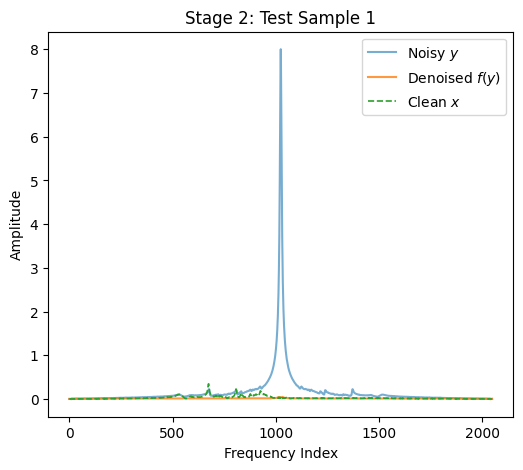

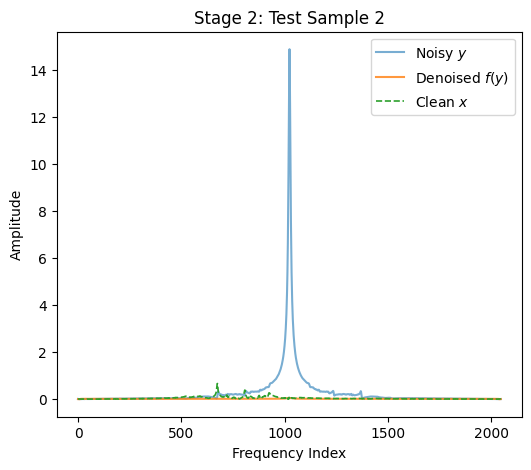

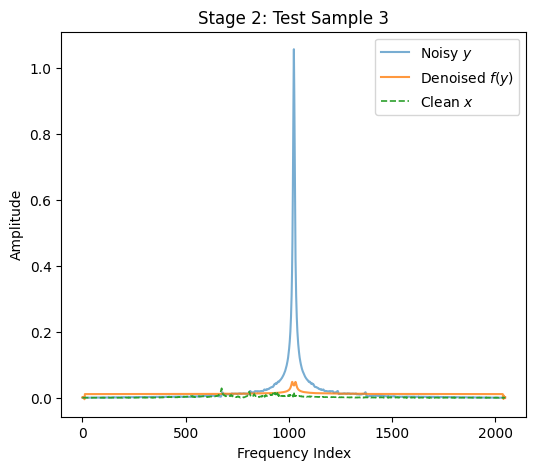

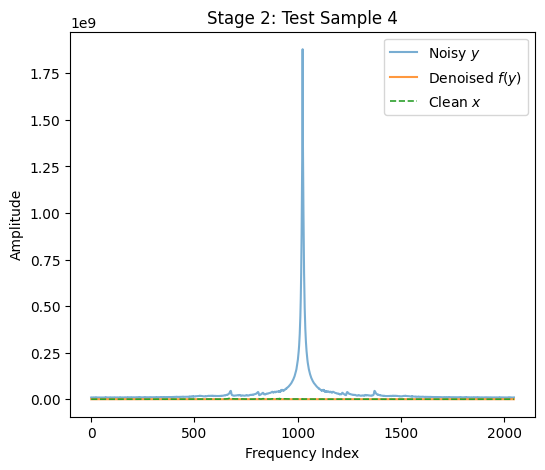

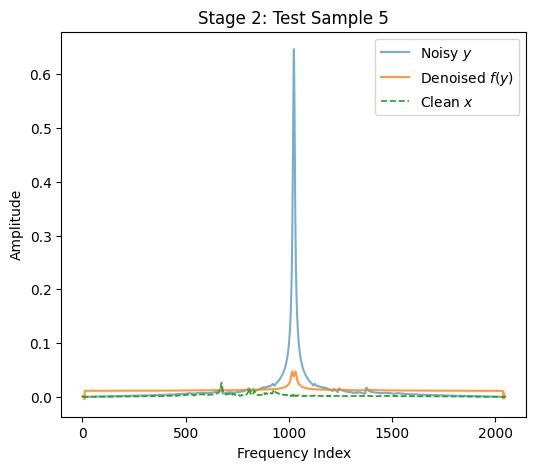

In [40]:
model2.load_state_dict(torch.load(model_2_save_path))
model2 = model2.to(device)
model2.eval()

mse_sum = 0.0
psnr_sum = 0.0
n_samples = 0

for raw, clean in tqdm(test_loader, desc="Validating", leave=False):
    raw, clean = raw.to(device), clean.to(device)

    # Apply L2 normalization (same as in training)
    raw_norm   = l2_normalize(raw)
    clean_norm = l2_normalize(clean)
    pred       = model2(raw_norm)

    # Compute normalized MSE
    batch_mse = nn.MSELoss(reduction="sum")(l2_normalize(pred), clean_norm).item()
    mse_sum += batch_mse

    # PSNR (unnormalized for interpretability)
    raw_np   = raw_norm.cpu().detach().numpy()
    clean_np = clean_norm.cpu().detach().numpy()
    pred_np  = pred.cpu().detach().numpy()
    for j in range(raw_np.shape[0]):
        dr = clean_np[j].max() - clean_np[j].min()
        psnr_sum += psnr(clean_np[j], pred_np[j], data_range=dr)

    n_samples += raw.size(0)

# Final metrics
test_mse = mse_sum / n_samples
avg_psnr = psnr_sum / n_samples

print(f"Test MSE (L2-normalized): {test_mse:.6f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

# Visualization
n_plots = 5
for raw, clean in test_loader:
    raw, clean = raw.to(device), clean.to(device)
    pred = model2(l2_normalize(raw))
    break  # first batch only

noisy_np = raw.cpu().detach().numpy()
clean_np = clean.cpu().detach().numpy()
pred_np  = pred.cpu().detach().numpy()

for i in range(n_plots):
    plt.figure(figsize=(6, 5))
    plt.plot(noisy_np[i], label="Noisy $y$", alpha=0.6)
    plt.plot(pred_np[i],  label="Denoised $f(y)$", alpha=0.8)
    plt.plot(clean_np[i], label="Clean $x$", linestyle="--", linewidth=1.2)
    plt.title(f"Stage 2: Test Sample {i+1}")
    plt.xlabel("Frequency Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()
